## Sequence to Sequence + Attention

自动翻译

![](http://img.huaiwen.me/20190122124610.png)

@部分代码和图片来自官方tutorials https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import random

In [3]:
MAX_LENGTH = 10
SOS_token = 0
EOS_token = 1
teacher_forcing_ratio = 0.5
hidden_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Encoder
![](http://img.huaiwen.me/20190122124745.png)

In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded.view(1,1,-1), hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1,1,self.hidden_size, device=device)

### Decoder
![](http://img.huaiwen.me/20190122125045.png)

In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.out(output[0])
        output = self.softmax(output)
        return output, hidden

### 带Attention的Decoder
![](http://img.huaiwen.me/20190122125145.png)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # attention 权重
        # [0.1, 0.7, 0.2]
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # 加权累加attention
        # [10, 2, 3]
        # [1, 1.4, 0.6]
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        # 讲input 和 attention 之后的值混合
        # [1,2,3] + [1, 1.4, 0.6]
        # [[1,2,3],[1, 1.4, 0.6]]
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # 大小，变成了正常的大小
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 加载数据

In [6]:
from seq2seq.data import prepare_data, tensors_from_pair

In [7]:
input_lang, output_lang, pairs = prepare_data('eng', 'chi', True)
print(random.choice(pairs))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Reading lines...


Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/huaiwen/anaconda3/lib/python3.6/site-packages/jieba/__init__.py", line 152, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmp267fvrb0' -> '/tmp/jieba.cache'
Loading model cost 0.953 seconds.
Prefix dict has been built succesfully.


Read 20294 sentence lpairs
Trimmed to 637 sentence pairs
Counting words...
Counted words:
chi 1038
eng 799
['我 對 音樂有 興趣 。', 'i am interested in music .']


In [10]:
print(random.choice(pairs))

['她 是 个 合格 的 护士 。', 'she is qualified as a nurse .']


### Encoder

In [24]:
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)

### Decoder

In [25]:
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

### 迭代训练

In [17]:
import time
from seq2seq.utils import time_since
import torch.optim as optim
from seq2seq.plot import mat_plot, show_plot

In [20]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # input_tensor 输入： 中文
    # target_tensor 输出： 英语
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # 输入句子长度
    input_length = input_tensor.size(0)
    # 输出句子长度
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    # 你 是 一个 好人
    for ei in range(input_length):
        # 输入一个字，以及上一个隐层值
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # decoder的解码
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # 随机进行训练矫正
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # 把ground-truth当做下一步的输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # 把ground-truth 放进去

    else:
        # 把上一步的结果，当做下一步的输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 把上一步预测的top 1 放进去

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
def train_iters(input_lang, output_lang, pairs, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0 
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(input_lang, output_lang, random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    show_plot(plot_losses)

In [26]:
train_iters(input_lang, output_lang, pairs, encoder, attn_decoder, n_iters=75000, print_every=5000)

1m 24s (- 19m 45s) (5000 6%) 2.6167
2m 49s (- 18m 20s) (10000 13%) 1.0569


KeyboardInterrupt: 

In [27]:
encoder.load_state_dict(torch.load('./data/encoder.pkl'))
attn_decoder.load_state_dict(torch.load('./data/decoder.pkl'))

In [29]:
from seq2seq.eval import evaluate, evaluate_randomly,evaluate_and_show_attention

In [30]:
evaluate_randomly(encoder, attn_decoder, input_lang, output_lang, pairs)

> 我 生性 樂觀 。
= i am an optimist by nature .
< i am an optimist by nature . <EOS>

> 他 沒 有 他 弟弟 聰明 。
= he is not as intelligent as his brother .
< he is not as intelligent as his brother . <EOS>

> 你們 不再 是 小孩 了 。
= you aren't kids anymore .
< you aren't kids anymore . <EOS>

> 我 厌恶 他 。
= i am disgusted with him .
< i am disgusted with him . <EOS>

> 他 的 职业 是 医生 。
= he is a doctor by profession .
< he is a doctor by profession . <EOS>

> 她 下 週要 去 法國 。
= she is going to france next week .
< she is going to france next week . <EOS>

> 他 是 个 钓鱼 专家 。
= he is an expert at fishing .
< he is an expert at fishing . <EOS>

> 她 像 白雪公主 一樣 漂亮 。
= she is as beautiful as snow white .
< she is as beautiful as snow white . <EOS>

> 他 正在 学 怎么 开车 。
= he is learning how to drive a car .
< he is learning how to drive a car . <EOS>

> 他 是 一個 友善 的 人 。
= he is a friendly person .
< he is a friendly person . <EOS>



['you', 'are', 'absolutely', 'right', '.', '<EOS>']


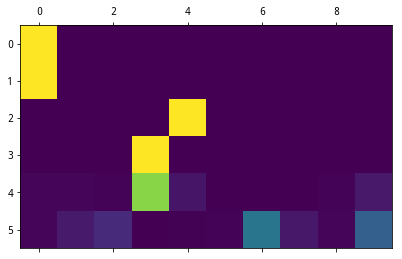

In [31]:
output_words, attentions = evaluate(encoder, attn_decoder, input_lang, output_lang, "你 完全 正確 。")
print(output_words)
mat_plot(attentions.numpy())

input = 他 对 结果 不 满意 。
output = he is unsatisfied with the result . <EOS>


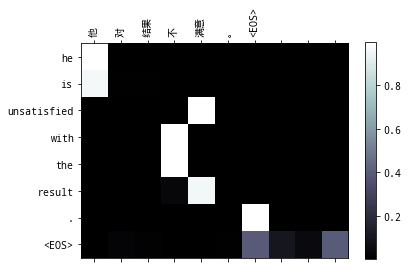

In [36]:
evaluate_and_show_attention(encoder, attn_decoder, input_lang, output_lang, "他 对 结果 不 满意 。")

In [35]:
print(random.choice(pairs))

['他 对 结果 不 满意 。', 'he is unsatisfied with the result .']
